In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 60.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchmetrics import Accuracy
import matplotlib.pyplot as plt


In [ ]:
classes = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship",
    "truck"
]


train_dataset = datasets.CIFAR10(root='./data',
                                      train=True, # Train dataset
                                      download=True,
                                      transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data',
                                     train=False, # Test dataset
                                     download=True,
                                     transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


Image shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, '6')

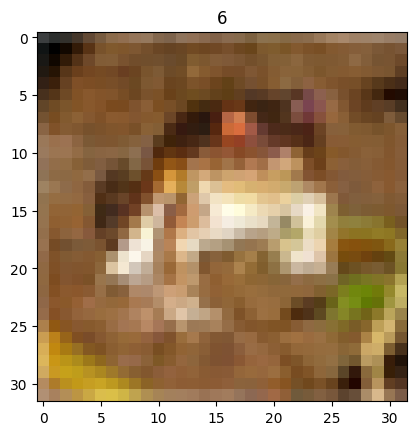

In [ ]:
image, label = train_dataset[0]
print(f"Image shape: {image.shape}")
# Reorder dimensions to (H, W, C)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title(label)


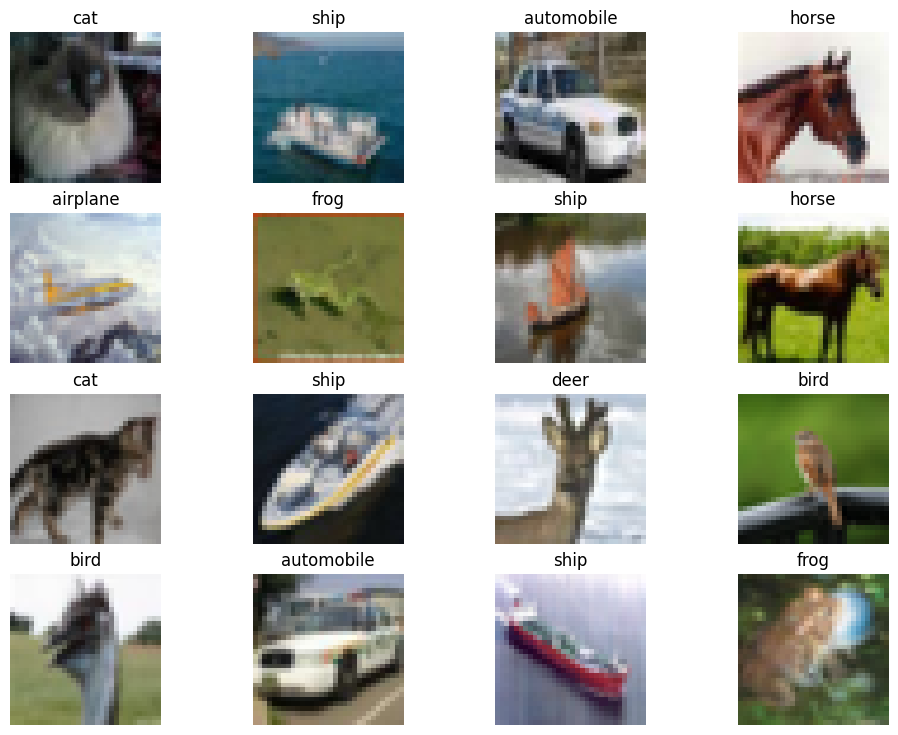

In [ ]:

figure = plt.figure(figsize=(12, 9))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()


In [ ]:
training_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=32,
                                                  shuffle=True,
                                                  drop_last=True)
testing_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=32,
                                                 shuffle=False,
                                                 drop_last=True)

print("DataLoaders created!")
print(f"Training batches: {len(training_dataloader)}")
print(f"Test batches: {len(testing_dataloader)}")


DataLoaders created!
Training batches: 1562
Test batches: 312


In [ ]:
# Let's see what our batches look like
for images, labels in training_dataloader:
    print(f"Batch shape: {images.shape}")  # [batch_size, 1, 28, 28]
    print(f"Labels shape: {labels.shape}") # [batch_size]
    print(f"First batch - Images: {images.shape}, Labels: {labels.shape}")
    break  # Just look at the first batch


Batch shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])
First batch - Images: torch.Size([32, 3, 32, 32]), Labels: torch.Size([32])


In [ ]:
import torch
from torch import nn

class MiniVGG(nn.Module):
    def __init__(self, output_shape=10):
        super().__init__()

        # Block 1: (3, 32, 32) → (32, 16, 16)
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Block 2: (32, 16, 16) → (64, 8, 8)
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, output_shape)
          )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x


# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

# Instantiate model
model = MiniVGG(output_shape=10).to(device)
print(model)

#model(torch.randn(32, 1, 28, 28).to(device))


Using cuda
MiniVGG(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


In [ ]:
EPOCHS = 10
total_epoch_count = []

accuracy_mc = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS + 1):
  model.train() # training mode
  train_loss, train_acc = 0, 0
  for batch_idx, (X, y) in enumerate(training_dataloader):
    X_train, y_train = X.to(device), y.to(device)
    logits = model(X_train)
    loss = loss_fn(logits, y_train)
    y_preds = logits.argmax(dim=1)

    # Backward + Optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc += accuracy_mc(y_preds, y_train)
    train_loss += loss

  # Testing
  model.eval() # eval mode
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in testing_dataloader:
      X_test, y_test = X.to(device), y.to(device)
      t_logits = model(X_test)
      t_loss = loss_fn(t_logits, y_test)
      t_y_preds = t_logits.argmax(dim=1)

      test_loss += t_loss
      test_acc += accuracy_mc(t_y_preds, y_test)

  avg_training_loss = train_loss / len(training_dataloader)
  avg_testing_loss = test_loss / len(testing_dataloader)
  avg_training_acc = train_acc / len(training_dataloader)
  avg_testing_acc = test_acc / len(testing_dataloader)

  # Print progress
  if epoch % 1 == 0 or epoch == 0 or epoch == EPOCHS:
      print(f"Epoch: {epoch} | "
            f"train_loss: {avg_training_loss:.3f} | "
            f"train_acc: {avg_training_acc:.3f} | "
            f"test_loss: {avg_testing_loss:.3f} | "
            f"test_acc: {avg_testing_acc:.3f} ")

Epoch: 0 | train_loss: 1.441 | train_acc: 0.484 | test_loss: 1.124 | test_acc: 0.606 
Epoch: 1 | train_loss: 1.015 | train_acc: 0.643 | test_loss: 0.977 | test_acc: 0.658 
Epoch: 2 | train_loss: 0.882 | train_acc: 0.692 | test_loss: 0.932 | test_acc: 0.669 
Epoch: 3 | train_loss: 0.794 | train_acc: 0.724 | test_loss: 0.832 | test_acc: 0.710 
Epoch: 4 | train_loss: 0.728 | train_acc: 0.747 | test_loss: 0.847 | test_acc: 0.711 
Epoch: 5 | train_loss: 0.677 | train_acc: 0.762 | test_loss: 0.810 | test_acc: 0.720 
Epoch: 6 | train_loss: 0.628 | train_acc: 0.779 | test_loss: 0.813 | test_acc: 0.725 
Epoch: 7 | train_loss: 0.585 | train_acc: 0.796 | test_loss: 0.798 | test_acc: 0.734 
Epoch: 8 | train_loss: 0.544 | train_acc: 0.810 | test_loss: 0.815 | test_acc: 0.737 
Epoch: 9 | train_loss: 0.504 | train_acc: 0.824 | test_loss: 0.856 | test_acc: 0.729 
Epoch: 10 | train_loss: 0.472 | train_acc: 0.834 | test_loss: 0.883 | test_acc: 0.720 
